# Style Transfer
* https://www.kaggle.com/code/ohseokkim/transfering-style

In [1]:
import os
import gc
import random
from datetime import datetime
import requests
from io import BytesIO

from PIL import Image

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(6) # Seed 고정

In [4]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/'

else:
    data_path = '../../data/'

In [5]:
if not os.path.exists(os.path.join(data_path, 'train_gen.csv')):
    df = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col='id')
    df.loc[3896, 'artist'] = 'Titian'
    df.loc[3986, 'artist'] = 'Alfred Sisley'
    df.to_csv(os.path.join(data_path, 'train_gen.csv'))

In [6]:
def get_artist_base(df_, user_count, gen_file_count,reverse=False):
    count_df = df_.groupby('artist')[['img_path']].agg('count').rename(columns={'img_path': 'count'}).sort_values(by='count')[:user_count].reset_index()
    for count in range(gen_file_count):
        if reverse:
            count_df[f'img_path_{count}']=count_df['artist'].apply(lambda name: df_.loc[df['artist']==name, 'img_path'].values[count])
        else:
            count_df[f'img_path_{count}']=count_df['artist'].apply(lambda name: df_.loc[df['artist']==name, 'img_path'].values[-count-1])
    return count_df

In [7]:
def get_data(df, idx):
    return df[f'img_path_{idx}'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [8]:
def load_image(img_path, image_size=520):
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
        ]
    )

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [9]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.detach().to("cpu").clone()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [10]:
def get_features(image, model):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [11]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [12]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
style_weights = {
    'conv1_1': 1,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1  # alpha
style_weight = 1e3  # beta

In [14]:
# iteration hyperparameters
def train(vgg, optimizer, target, style_grams, content_features):
    steps = 10000
    loss_threshold = 300

    for ii in range(1, steps+1):

        # get the features from your target image
        target_features = get_features(target, vgg)

        # the content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # the style loss
        # initialize the style loss to 0
        style_loss = 0
        # then add to it for each layer's gram matrix loss
        for layer in style_weights:
            # get the "target" style representation for the layer
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            # get the "style" style representation
            style_gram = style_grams[layer]
            # the style loss for one layer, weighted appropriately
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            # add to the style loss
            style_loss += layer_style_loss / (d * h * w)

        # calculate the *total* loss
        total_loss = content_weight * content_loss + style_weight * style_loss

        # update your target image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if  ii % 2000 == 0:
            print(f'{ii}, Total loss : {total_loss.item()}')
        if total_loss.item() < loss_threshold:
            print(f'{ii}, early stopping, Total loss : {total_loss.item()}')
            break

In [15]:
base_path = os.path.join(data_path, 'base_images')
gen_path = os.path.join(data_path, 'gen_images')
os.makedirs(gen_path, exist_ok=True)

In [16]:
def generate_image(df_, gen_file_count, count_df, start_base_idx=0):
    df_ = df_.copy()
    for file_idx in range(gen_file_count):
        img_paths, labels = get_data(count_df, file_idx)
        for artist_idx in range(len(img_paths)):
            vgg = models.vgg19(pretrained=True).features
            for param in vgg.parameters():
                param.requires_grad_(False)
            vgg.to(device)
    
            content = load_image(os.path.join(base_path, f'base_{start_base_idx+file_idx}.jpg')).to(device)
            style = load_image(img_paths[artist_idx]).to(device)
            artist = labels[artist_idx]
    
            content_features = get_features(content, vgg)
            style_features = get_features(style, vgg)
    
            style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
            target = content.clone().requires_grad_(True).to(device)
            optimizer = optim.Adam([target], lr=0.003)
    
            train(vgg, optimizer, target, style_grams, content_features)
    
            image = im_convert(target)
            img_test = Image.fromarray(np.uint8(image*255)) # NumPy array to PIL image
            output_file_name = f'./gen_images/base_{start_base_idx+file_idx}_{artist_idx}_gen.jpg'
            img_test.save(os.path.join(data_path, output_file_name),'JPEG')
            df_ = pd.concat([df_, pd.DataFrame({'artist':[artist], 'img_path':[output_file_name]})], ignore_index=True)
            clear_mem()
    df_.to_csv(os.path.join(data_path, 'train_gen.csv'), index_label='id')

In [17]:
user_count = 11
gen_count = 5
df = pd.read_csv(os.path.join(data_path, 'train_gen.csv'), index_col='id')
base_df = get_artist_base(df, user_count, gen_count)
generate_image(df, gen_count, base_df)

2000, Total loss : 4059.814208984375
4000, Total loss : 630.328369140625
5055, early stopping, Total loss : 299.8684387207031
2000, Total loss : 6848.2470703125
4000, Total loss : 3477.07568359375
5868, early stopping, Total loss : 299.942626953125
2000, Total loss : 1775.8865966796875
3426, early stopping, Total loss : 299.9168701171875
2000, Total loss : 11778.0673828125
4000, Total loss : 2065.3974609375
5231, early stopping, Total loss : 299.5995788574219
2000, Total loss : 1847.9959716796875
4000, Total loss : 877.720703125
5798, early stopping, Total loss : 299.8532409667969
2000, Total loss : 1577.840576171875
4000, Total loss : 807.8175659179688
5712, early stopping, Total loss : 299.85968017578125
2000, Total loss : 6698.2392578125
4000, Total loss : 1314.00927734375
4658, early stopping, Total loss : 299.6548156738281
2000, Total loss : 7042.5244140625
4000, Total loss : 3032.26806640625
6000, Total loss : 1345.3369140625
8000, Total loss : 365.87652587890625
8277, early stop

In [20]:
user_count = 6
gen_count = 5
df = pd.read_csv(os.path.join(data_path, 'train_gen.csv'), index_col='id')
base_df = get_artist_base(df, user_count, gen_count, reverse=True)
generate_image(df, gen_count, base_df,start_base_idx=5)

2000, Total loss : 8034.77099609375
4000, Total loss : 1729.24267578125
6000, Total loss : 508.617919921875
7011, early stopping, Total loss : 299.87109375
2000, Total loss : 8519.498046875
4000, Total loss : 2289.568603515625
6000, Total loss : 699.0438842773438
7435, early stopping, Total loss : 299.9486083984375
2000, Total loss : 1204.4188232421875
3647, early stopping, Total loss : 299.84698486328125
2000, Total loss : 6000.48681640625
4000, Total loss : 1866.5767822265625
6000, Total loss : 795.3182983398438
7840, early stopping, Total loss : 299.9988098144531
2000, Total loss : 880.1299438476562
3887, early stopping, Total loss : 299.9652099609375
2000, Total loss : 455.875732421875
2744, early stopping, Total loss : 299.85467529296875
2000, Total loss : 5010.11328125
4000, Total loss : 1122.9619140625
6000, Total loss : 396.2369384765625
6696, early stopping, Total loss : 299.945068359375
2000, Total loss : 4669.13623046875
4000, Total loss : 1946.615966796875
6000, Total loss 

In [28]:
df = pd.read_csv(os.path.join(data_path, 'train_gen.csv'), index_col='id')
count_df = df.groupby(['artist']).agg('count')
count_df

,img_path
artist,
Albrecht Du rer,220
Alfred Sisley,164
Amedeo Modigliani,132
Andrei Rublev,74
Andy Warhol,132
Camille Pissarro,64
Caravaggio,42
Claude Monet,59
Diego Rivera,55


<Axes: >

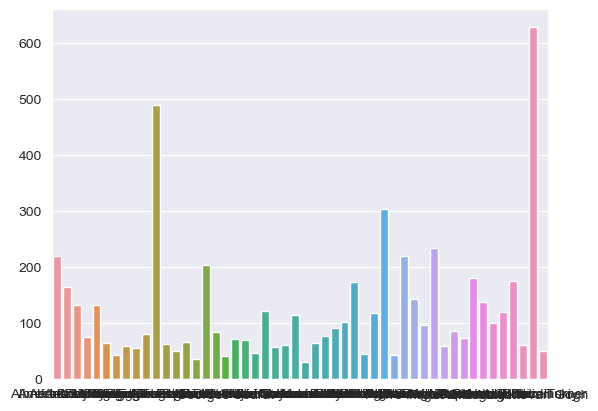

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=list(count_df.index), y=list(count_df['img_path']))